# Cythonizing the point lens class
## Result: 
### (i) We obtain ~4.5x speedup in the Wave optics regime,
### (ii) ~45x speedup in the Quasi-Geometrical optics regime,
### (iii) ~25x speedup in the Geometrical optics regime.

In [1]:
%load_ext cython

In [2]:
import numpy as np

import time
import sys

import mpmath
from mpmath import hyp1f1
import math
import matplotlib.pyplot as plt

import scipy
import math
from tqdm import tqdm
from itertools import product

from astropy.io import fits
from functools import partial


In [3]:
# Cython compiles in C, so a C comiler is a must. It basically works in three steps:
# (i) Cython firsly converts the python/cython code to C;
# (ii) the C compiler then translates that into a shared library/extension module;
# (iii) this extension module is then imported to python and used.

import sys
import Cython
import numpy as np
import subprocess, os
print("Python %d.%d.%d %s %s" % sys.version_info)
print("Cython %s" % Cython.__version__)
print("NumPy  %s" % np.__version__)
print(subprocess.check_output([os.environ.get('CC', 'cc'), "--version"]).decode().splitlines()[0])
print([line for line in subprocess.check_output([os.environ.get('CC', 'cc'), "--version", "-v"],
                                                stderr=subprocess.STDOUT).decode().splitlines()
       if ' version ' in line][0])

Python 3.9.13 final 0
Cython 0.29.30
NumPy  1.22.4
x86_64-conda-linux-gnu-cc (conda-forge gcc 10.3.0-16) 10.3.0
gcc version 10.3.0 (conda-forge gcc 10.3.0-16) 


#### Function to compare timings

In [4]:
timings = dict()

def ratios(**new):
    ts_rats, keys = [], []
    assert len(new) == 1
    timings.update(**new)
    new_val = list(new.values())[0]
    for key, t in list(timings.items()):
        ts_rats.append(t/new_val)
        keys.append(key)
        # print(key, )
    ts_rats = np.array(ts_rats)
    keys = np.array(keys)
    keys = keys[np.argsort(ts_rats)] 
    ts_rats = ts_rats[np.argsort(ts_rats)] 
    ts_rats = ts_rats/ts_rats[0]
    keys = keys[np.argsort(ts_rats)] 
    [print('{}: {}'.format(r[0], r[1])) for r in np.transpose([keys, ts_rats])][0]

### Checking problematic values

In [5]:
%%cython --cplus 

import Cython
import cython
timings = dict()
import numpy as np
import mpmath
from mpmath import hyp1f1
import math
import matplotlib.pyplot as plt

import scipy
import math
from tqdm import tqdm
from itertools import product

import cython
cimport libc.math
from scipy.special.cython_special cimport gamma #, hyp1f1

cdef extern from "complex.h" namespace "std" nogil:
    long double complex exp(long double complex)
    long double real(long double complex z)
    long double imag(long double complex z)
    
import gmpy2
from gmpy2 import mpc    
gmpy2.set_context(gmpy2.context(real_prec=100,imag_prec=100))
gmpy2.get_context()

# w=10
# mlz, y = 1e5, 0.01
# xm = (y+libc.math.sqrt(y*y + 4.))/2.
# pm = ((xm-y)**2)/2 - libc.math.log(xm)
# hp = libc.math.log(w/2.)-(2.*pm)
# print((libc.math.pi*w/4.)+1j*(hp*w/2.))
# h = gmpy2.exp((libc.math.pi*w/4.)+1j*(hp*w/2.))
# h2 = exp((libc.math.pi*w/4.)+1j*(hp*w/2.))
# print(h)
# print(h2)

# print(np.exp(898984654658494*1j))   3 imaginary values are not affected as they are simply rotations
# w=890
# tmp_fac=1.-(1j*w/2.)
# print(tmp_fac)
# print(gamma(tmp_fac))

# gm = gamma(1.-(1j*3.61577/2.))
# #this approach was not adopted to avoid if-else condition
# if gm.imag>0:
#     print(str(gm.real) + '+' + str(gm.imag) + 'j')
# else:    
#     print(str(gm.real) + str(gm.imag) + 'j')
    
gms = []
ws = np.linspace(1, 900, 10)
for w in tqdm(ws):
    tmp_fac=1.-(1j*w/2.)
    gms.append(gamma(tmp_fac))
 

w=990.6226295405025
mlz, y = 1e5, 0.01
xm = (y+libc.math.sqrt(y*y + 4.))/2.
pm = ((xm-y)**2)/2 - libc.math.log(xm)
hp = libc.math.log(w/2.)-(2.*pm)
tmp_fac = (libc.math.pi*w/4.)+1j*(hp*w/2.)
print(tmp_fac)
if real(tmp_fac) < 709:   # because e^709 is max value for long double; after which it just returns infinite
    h = exp(tmp_fac)
else:    
    h = gmpy2.exp(tmp_fac)
    
if w < 900:               # since gamma is strictly decreasing func, after roughly w~900, gamma val goes below e^308 and so long double return 0
    gm = gamma(1.-(1j*w/2.))
else:
    gm = mpmath.gamma(1.-(1j*w/2.))  
hf = hyp1f1((1j*w/2.),1., (1j*y*y*w/2.))


if gm.imag>0:
    gm = mpc(str(gm.real) + '+' + str(gm.imag) + 'j')
else:    
    gm = mpc(str(gm.real) + str(gm.imag) + 'j')

if hf.imag>0:
    hf = mpc(str(hf.real) + '+' + str(hf.imag) + 'j')
else:    
    hf = mpc(str(hf.real) + str(hf.imag) + 'j')  

# Ff = np.complex128(h)*gm*hf
Ff = gmpy2.mul(h*gm, hf)
# print(h)
print(gm)
print(hf)
print(Ff)
print(real(Ff)+1j*imag(Ff) )



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 102550.22it/s]

(778.0331938610615+2588.0692628266497j)
-6.830065962010660000000000000001e-337-1.9239812299880500000000000000011e-337j
-0.24068477452295699999999999999999-0.0062961114487563400000000000000017j
12.822278411587161837010421612225-3.9994729752664595398364970650105j
(12.822278411587162-3.9994729752664595j)


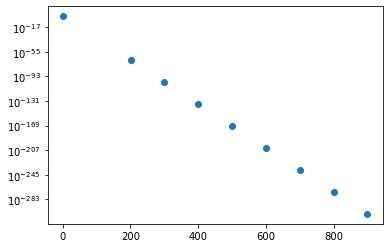

In [7]:
plt.scatter(ws, np.real(gms))
plt.yscale('log')

## Final Cythonized code

In [8]:
%%cython --cplus -a
# distutils: language = c++

timings = dict()
import numpy as np

import time
import sys

import mpmath
from mpmath import hyp1f1
import math
import matplotlib.pyplot as plt

import scipy
import math
from tqdm import tqdm
from itertools import product

from astropy.io import fits
from functools import partial

import multiprocessing as mp
npool = 1  # int(sys.argv[1])

cdef double G = 6.67430*1e-11 
cdef double c = 299792458. 
cdef double M_sun = 1.989*1e30

import cython
cimport libc.math
#scipy's gamma is long double so will use mpmath.gamma for cases where the former returns 0 )
#scipy's hyp1f1 doesn't support complex so will use mpmath.hyp1f1
from scipy.special.cython_special cimport gamma #, hyp1f1
cdef extern from "complex.h" namespace "std" nogil:
    long double complex exp(long double complex)
    long double real(long double complex z)
    long double imag(long double complex z)

import gmpy2
from gmpy2 import mpc    
gmpy2.set_context(gmpy2.context(real_prec=400,imag_prec=400))
gmpy2.get_context()

# User Defined Classes
cdef class point_lens_cython:
    '''
    A class containing functions for studying an isolated point lens case. 
    In such cases, two images are formed: one minima (type I) and one saddle (type II). 
    '''
    
    # image positions
    cdef double x_minima(self, double y):
        return (y+libc.math.sqrt(y**2.+4.))/2.
    cdef double x_saddle(self, double y):
        return (y-libc.math.sqrt(y**2.+4.))/2.
    
    #image magnifications
    @cython.cdivision(True)
    cdef double magification_minima(self, double y):
        return 1/2. + (y**2.+2.)/(2.*y*libc.math.sqrt(y**2.+4.))  
    @cython.cdivision(True)
    cdef double magification_saddle(self, double y):
        return 1/2. - (y**2.+2.)/(2.*y*libc.math.sqrt(y**2.+4.))

    #time delay between the two images
    @cython.cdivision(True)
    cdef double td_point_dimensionless(self, double y):
        return (y*libc.math.sqrt(y**2.+4.))/2. + libc.math.log((libc.math.sqrt(y**2.+4.)+y)/(libc.math.sqrt(y**2.+4.)-y))
    @cython.cdivision(True)
    cdef double td_point_sec(self, double ml, double y, double zl=0):
        return (4.*G*M_sun*ml*(1.+zl)/c**3.)*((y*libc.math.sqrt(y**2.+4.))/2. + libc.math.log((libc.math.sqrt(y**2.+4.)+y)/(libc.math.sqrt(y**2+4)-y)))

    # Geometric and Quasi Geometric approximations
    cdef double complex point_Fw_geo(self, double w, double y):
        return libc.math.sqrt(libc.math.fabs(self.magification_minima(y))) - 1j*libc.math.sqrt(libc.math.fabs(self.magification_saddle(y)))*exp(1j*w*self.td_point_dimensionless(y))
    
    @cython.cdivision(True)
    cdef double complex point_Fw_qgeo(self, double w, double y):
        return self.point_Fw_geo(w,y) + (1j/(3.*w))*((4.*self.x_minima(y)**2.-1.)/(((self.x_minima(y)**2.+1.)**3.)*(self.x_minima(y)**2.-1.)))*libc.math.sqrt(libc.math.fabs(self.magification_minima(y))) + (1./(3*w))*((4.*self.x_saddle(y)**2.-1.)/(((self.x_saddle(y)**2.+1.)**3.)*(self.x_saddle(y)**2.-1.)))*libc.math.sqrt(libc.math.fabs(self.magification_saddle(y)))*exp(1j*w*self.td_point_dimensionless(y)) 
     
    # dimensionless frequency (w) in terms of dimensionfull frequency (f), w(f)
    @cython.cdivision(True)
    #@cython.boundscheck(False)
    cdef double w_of_f(self, double f, double ml, double zl=0):
        wf = f*8.*libc.math.pi*G*ml*(1.+zl)*M_sun/c**3.
        return wf
    
    # dimensionfull frequency (f) in terms of dimensionless frequency (w), f(w)
    @cython.cdivision(True)
    cdef double f_of_w(self, double w, double ml, double zl=0):
        fw = w * (c**3) / (8.*libc.math.pi*G*ml*(1.+zl)*M_sun)        
        return fw

    cdef double wc_geo_re0p1(self, double y):
    # returns wc(y) (cutoff w for a given y) such that w > wc gives relative error < 0.1 % when 
    # geometric optics is used. Valid for y in range (0.01, 5.00)
        if 0.01 <= y <= 0.12:
            wc = 15112.5 - 52563.5*y
        elif 0.12 < y <= 1.5:
            wc = -34.08 - 12.84*(y**(-1)) + 114.33*(y**(-2)) + 0.89*(y**(-3)) 
        elif 1.5 < y < 5.01:
            wc = -15.02 + 18.25*y - 2.66*y**2
        else:
            print('Warning: y = {} is outside interpolation range (0.01, 5.00). Thus, Extrapolating! '.format(y))
        return wc


    # same for Quasi Geometric approximation  
    cdef double wc_Qgeo_re0p1(self, double y):
        if 0.01 <= y <= 5.01:
            wc = 9*(y**(-1)) + 0.04*(y**(-2))
        else:
            print('Warning: y = {} is outside interpolation range (0.01, 5.00). Thus, Extrapolating! '.format(y))
        return wc  

    #same for 1% relative error
    cdef double wc_geo_re1p0(self, double y):
        if 0.01 <= y <= 0.071:
            wc = 16604 - 202686*y
        elif 0.071 < y <= 5.01:
            wc = 0.64 + 0.97*(y**(-1)) + 6*(y**(-2)) + 0.38*(y**(-3))  
        else:
            print('Warning: y = {} is outside interpolation range (0.01, 5.00). Thus, Extrapolating! '.format(y))
        return wc

    cdef double wc_Qgeo_re1p0(self, double y):
        if 0.01 <= y <= 5.01:
            wc = 4*(y**(-1)) - libc.math.log(y)/5 
        else:
            print('Warning: y = {} is outside interpolation range (0.01, 5.00). Thus, Extrapolating! '.format(y))
        return wc  
    
       
    # Amplification Factor, F(w, y), for point lens using actual analytic formula. 
    # It breaks down, or is difficult to compute, when the system approaches geometrical optics regime.
    cdef long double complex point_Fw(self, long double w, double y):
        cdef long double xm, pm, hp,
        cdef long double complex hf, Ff, tmp_fac
        if w==0:
            return 1
        else:
            xm = (y+libc.math.sqrt(y*y + 4.))/2.
            pm = ((xm-y)**2)/2 - libc.math.log(xm)
            hp = libc.math.log(w/2.)-(2.*pm)
            tmp_fac = (libc.math.pi*w/4.)+1j*(hp*w/2.) 
            if real(tmp_fac) < 709:   # because e^709 is max value for long double; after which it just returns infinite
                h = exp(tmp_fac)
            else:    
                h = gmpy2.exp(tmp_fac)
            if w < 900:               # since gamma is strictly decreasing func, after roughly w~900, gamma val goes below e^308 and so long double return 0
                gm = gamma(1.-(1j*w/2.))
            else:
                gm = mpmath.gamma(1.-(1j*w/2.))       
            hf = hyp1f1((1j*w/2.),1., (1j*y*y*w/2.))
            
            # converting gm and hf to mpc objects
            if gm.imag>0:
                gm = mpc(str(gm.real) + '+' + str(gm.imag) + 'j')
            else:    
                gm = mpc(str(gm.real) + str(gm.imag) + 'j')

            if hf.imag>0:
                hf = mpc(str(hf.real) + '+' + str(hf.imag) + 'j')
            else:    
                hf = mpc(str(hf.real) + str(hf.imag) + 'j')  

#             try:
#                 gm = mpc(str(gm.real) + '+' + str(gm.imag) + 'j')
#             except ValueError:
#                 gm = mpc(str(gm.real) + str(gm.imag) + 'j')
            
#             try:
#                 hf = mpc(str(hf.real) + '+' + str(hf.imag) + 'j')
#             except ValueError:
#                 hf = mpc(str(hf.real) + str(hf.imag) + 'j') 
                
            Ff = gmpy2.mul(h*gm, hf)   #gmpy is necessary for precision.
            return real(Ff)+1j*imag(Ff)  

    # An efficient computation that uses our knowledge from the geometric optics limit. 
    # It can handle any values.
    cdef double complex point_Fw_eff(self, double w, double y):
        wc_geo = self.wc_geo_re0p1(y)
        wc_Qgeo = self.wc_Qgeo_re0p1(y)
        if w < wc_Qgeo:
            return self.point_Fw(w,y)
        elif ((w>=wc_Qgeo)&(w<wc_geo)):
            return self.point_Fw_qgeo(w,y)
        else:
            return self.point_Fw_geo(w,y)

    cdef double complex point_Ff_eff(self, double f, double ml, double y, double zl=0):
        w = self.w_of_f(f, ml, zl)
        return  self.point_Fw_eff(w, y)         
        
import pnt_lens_class 
pnt_lens_py = pnt_lens_class.point_lens()

cdef point_lens_cython pnt_lens_cy_cdef = point_lens_cython()

t1 = time.time()
Mlzs = np.logspace(1, 4, 5)
ys = np.logspace(-2, np.log10(3), 5)
input_prms = list(product(Mlzs, ys))
fs = np.arange(0, 1024, 1/4)
for inp in tqdm(input_prms):
    Mlz, y = inp
    wfs = [pnt_lens_cy_cdef.w_of_f(f, ml=Mlz, zl=0) for f in fs]
    Ffs = [pnt_lens_cy_cdef.point_Fw_eff(wf, y=y) for wf in wfs]
t2 = time.time()    
t_cy_cdef = (t2-t1)/len(input_prms)
print('avg. time (cython) = {:.5f}'.format(t_cy_cdef) ) 


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.05it/s]

avg. time (cython) = 0.19830


In [9]:
ratios(cython_cdef=t_cy_cdef)

cython_cdef: 1.0


In [10]:
import pnt_lens_class 
pnt_lens_py = pnt_lens_class.point_lens()
import cythonized_pnt_lens_class as pnt_lens_cy
from itertools import product

In [11]:
t1 = time.time()
Mlzs = np.logspace(1, 4, 5)
ys = np.logspace(-2, np.log10(3), 5)
input_prms = list(product(Mlzs, ys))
fs = np.arange(0, 1024, 1/4)
for inp in tqdm(input_prms):
    Mlz, y = inp
    wfs = [pnt_lens_py.w_of_f(f, ml=Mlz, zl=0) for f in fs]
    Ffs = [pnt_lens_py.point_Fw_eff(wf, y=y) for wf in wfs]
t2 = time.time()    
t_py = (t2-t1)/len(input_prms)
print('avg. time (python) = {:.5f}'.format(t_py) )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:21<00:00,  1.17it/s]

avg. time (python) = 0.85191


In [12]:
ratios(python=t_py)

cython_cdef: 1.0
python: 4.296123360237957


In [13]:
import cython

t1 = time.time()
Mlzs = np.logspace(1, 4, 5)
ys = np.logspace(-2, np.log10(3), 5)
input_prms = list(product(Mlzs, ys))
fs = np.arange(0, 1024, 1/4)
for inp in tqdm(input_prms):
    Mlz, y = inp
    wfs = [pnt_lens_cy.w_of_f(f, ml=Mlz, zl=0) for f in fs]
    Ffs = [pnt_lens_cy.point_Fw_eff(wf, y=y) for wf in wfs]
t2 = time.time()          
t_cy = (t2-t1)/len(input_prms)
print('avg. time (cython) = {:.5f}'.format(t_cy) )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.08it/s]

avg. time (cython) = 0.19703


In [14]:
ratios(cython_cpdef=t_cy)

cython_cpdef: 1.0
cython_cdef: 1.0064500939728116
python: 4.323833759630284


### Conclusion: So Cythonized class is ~4.5x better than Python !!!!!!

## Performance in Qgeo optics

In [15]:
timings = dict()
t1 = time.time()
Mlzs = np.logspace(1, 4, 5)
ys = np.logspace(-2, np.log10(3), 5)
input_prms = list(product(Mlzs, ys))
fs = np.arange(0.25, 1024, 1/4)
for inp in tqdm(input_prms):
    Mlz, y = inp
    wfs = [pnt_lens_py.w_of_f(f, ml=Mlz, zl=0) for f in fs]
    Ffs = [pnt_lens_py.point_Fw_qgeo(wf, y=y) for wf in wfs]
t2 = time.time()    
t_py = (t2-t1)/len(input_prms)
print('avg. time (python) = {:.5f}'.format(t_py) )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:05<00:00,  4.73it/s]

avg. time (python) = 0.21152


In [16]:
ratios(python=t_py)

python: 1.0


In [17]:
t1 = time.time()
Mlzs = np.logspace(1, 4, 5)
ys = np.logspace(-2, np.log10(3), 5)
input_prms = list(product(Mlzs, ys))
fs = np.arange(0.25, 1024, 1/4)
for inp in tqdm(input_prms):
    Mlz, y = inp
    wfs = [pnt_lens_cy.w_of_f(f, ml=Mlz, zl=0) for f in fs]
    Ffs = [pnt_lens_cy.point_Fw_qgeo(wf, y=y) for wf in wfs]
t2 = time.time()          
t_cy = (t2-t1)/len(input_prms)
print('avg. time (cython) = {:.5f}'.format(t_cy) )

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 231.66it/s]

avg. time (cython) = 0.00449


In [18]:
ratios(cython=t_cy)

cython: 1.0
python: 47.123564518836275


### Conclusion: So Cythonized class is ~45x better than Python in the Quasi-Geometric Optics limit!!!!!!

## Performance in Geo optics

In [19]:
timings = dict()
t1 = time.time()
Mlzs = np.logspace(1, 4, 5)
ys = np.logspace(-2, np.log10(3), 5)
input_prms = list(product(Mlzs, ys))
fs = np.arange(0.25, 1024, 1/4)
for inp in tqdm(input_prms):
    Mlz, y = inp
    wfs = [pnt_lens_py.w_of_f(f, ml=Mlz, zl=0) for f in fs]
    Ffs = [pnt_lens_py.point_Fw_geo(wf, y=y) for wf in wfs]
t2 = time.time()    
t_py = (t2-t1)/len(input_prms)
print('avg. time (python) = {:.5f}'.format(t_py) )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 12.54it/s]

avg. time (python) = 0.07990


In [20]:
ratios(python=t_py)

python: 1.0


In [21]:
t1 = time.time()
Mlzs = np.logspace(1, 4, 5)
ys = np.logspace(-2, np.log10(3), 5)
input_prms = list(product(Mlzs, ys))
fs = np.arange(0.25, 1024, 1/4)
for inp in tqdm(input_prms):
    Mlz, y = inp
    wfs = [pnt_lens_cy.w_of_f(f, ml=Mlz, zl=0) for f in fs]
    Ffs = [pnt_lens_cy.point_Fw_geo(wf, y=y) for wf in wfs]
t2 = time.time()          
t_cy = (t2-t1)/len(input_prms)
print('avg. time (cython) = {:.5f}'.format(t_cy) )

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 316.23it/s]

avg. time (cython) = 0.00341


In [22]:
ratios(cython=t_cy)

cython: 1.0
python: 23.452640625262436


### Conclusion: So Cythonized class is ~25x better than Python in the Geometric Optics limit!!!!!!